Dieses Notebook ist angelehnt an das Buch *Python Data Science Handbook* von Jake VanderPlas, auch verfügbar auf [GitHubPages](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic).

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Praktikum: Session 5
[Video](https://mstream.hm.edu/paella/ui/watch.html?id=bcb4dac3-6114-475e-a5ef-436926cf0497)

In dieser Session stehen zwei Punkte im Vordergrund:

1.   Datenaufbereitung
2.   Interpretation von Modellen

Um den zweiten Punkt gut abbilden zu können, verwenden wir ein lineares Modell.

Als Anwendungsfall betrachten wir die Anzahl der Fahrradfahrten über die Fremont Bridge in Seattle (dort sind entsprechende Sensoren installiert und die Daten seit Oktober 2012 verfügbar). Ziel ist es, diese Anzahl der Fahrten für einen gegebenen Tag vorherzusagen. Zu diesem Zweck wollen wir ein lineares Modell erstellen.

## 1. (Roh-)Daten
Die Rohdaten der Fremont Bridge können einfach heruntergeladen werden:

In [ ]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 15536    0 15536    0     0  12871      0 --:--:--  0:00:01 --:--:-- 12860
100 1742k    0 1742k    0     0   812k      0 --:--:--  0:00:02 --:--:--  812k
100 3550k    0 3550k    0     0  1106k      0 --:--:--  0:00:03 --:--:-- 1106k
100 4248k    0 4248k    0     0  1134k      0 --:--:--  0:00:03 --:--:-- 1133k


In [ ]:
import pandas as pd
counts = pd.read_csv('/content/FremontBridge.csv', index_col='Date', parse_dates=True)

In [ ]:
counts

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0
...,...,...,...
2020-09-30 19:00:00,156.0,51.0,105.0
2020-09-30 20:00:00,70.0,27.0,43.0
2020-09-30 21:00:00,40.0,17.0,23.0


### 0. Säuberung der Daten
Leider enthält dieser Datensatz (Stand 11.11.2020) einen Großteil der Daten doppelt:

In [ ]:
print("counts enthält %d Einträge." % counts.index.shape)
print("Es gibt aber nur %d einzigartige Zeitstempel." % counts.index.unique().shape)
print("Hier ein Auszug aus der Häufigkeitsverteilung:")
counts.index.value_counts()

counts enthält 136334 Einträge.
Es gibt aber nur 70080 einzigartige Zeitstempel.
Hier ein Auszug aus der Häufigkeitsverteilung:


2019-06-15 03:00:00    2
2016-02-18 09:00:00    2
2018-03-21 17:00:00    2
2013-08-26 17:00:00    2
2019-05-21 16:00:00    2
                      ..
2020-07-10 08:00:00    1
2020-06-08 13:00:00    1
2020-09-12 21:00:00    1
2020-03-30 14:00:00    1
2020-03-29 15:00:00    1
Name: Date, Length: 70080, dtype: int64

Bevor wir diese entfernen, sollten wir prüfen, ob es fehlende Daten gibt. Diese sollten ggf. entfernt werden, **bevor** doppelte Zeilen gelöscht werden (*warum?*).

In [ ]:
counts[counts.isna().any(axis=1)]

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2013-06-14 09:00:00,NaN,NaN,NaN
2013-06-14 10:00:00,NaN,NaN,NaN
2014-03-09 02:00:00,NaN,NaN,NaN
2015-03-08 02:00:00,NaN,NaN,NaN
2015-04-21 11:00:00,NaN,NaN,NaN
2015-04-21 12:00:00,NaN,NaN,NaN
2016-03-13 02:00:00,NaN,NaN,NaN
2017-03-12 02:00:00,NaN,NaN,NaN
2018-03-11 02:00:00,NaN,NaN,NaN


Es gibt also 21 Zeilen, die fehlende Daten enthalten. Da wir wissen, dass es Doppelungen in den Indices gibt, besteht die Chance, dass die hier fehlenden Daten in der gedoppelten Zeile eingetragen sind. Prüfen wir das:

In [ ]:
counts.loc[counts[counts.isna().any(axis=1)].index]

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2013-06-14 09:00:00,NaN,NaN,NaN
2013-06-14 09:00:00,NaN,NaN,NaN
2013-06-14 10:00:00,NaN,NaN,NaN
2013-06-14 10:00:00,NaN,NaN,NaN
2014-03-09 02:00:00,NaN,NaN,NaN
2014-03-09 02:00:00,NaN,NaN,NaN
2015-03-08 02:00:00,NaN,NaN,NaN
2015-03-08 02:00:00,NaN,NaN,NaN
2015-04-21 11:00:00,NaN,NaN,NaN


Eine Korrektur rentiert sich hier wohl eher nicht... Daher löschen wir sie:

In [ ]:
counts.dropna(inplace=True)

Nun wollen wir diejenigen Zeilen, der Index (also der Zeitstempel) doppelt auftreten löschen; genauer: wir wollen die Doppelungen löschen, die jeweils erste Instanz soll beibehalten werden.

Mit ``counts.index`` können wir auf den Index zugreifen. Die Methode ``duplicated()`` liefert uns Informationen darüber, ab es sich jeweils um ein Duplikat handelt (``True``) oder nicht (``False``). Die jeweils erste Instanz wird dabei nicht als Duplikat markiert. Durch den Operator ``~`` können wir eine logische Negation durchführen und erhalten damit einen Index, der genau dort den Wert ``True`` hat, wo *kein* Duplikat steht. Die dazu korrespondierenden Zeilen wollen wir behalten.

In [ ]:
~counts.index.duplicated()

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
counts = counts[~counts.index.duplicated()]

In [ ]:
counts.index.shape

(70070,)

Offenbar sind hier die Überquerungen in einem Stundenraster vorhanden. Außerdem ist neben dem Gesamtverkehr auch noch die Aufteilung in östliche und westliche Sput vorhanden (westlich: Richtung Downtown). Wir wollen diese Daten noch abändern, denn:
- Wir sind nur am gesamten Verkehr interessiert.
- Wir interessieren uns nur für die gesamten Überquerungen eines ganzen Tages.

Für diese für uns relevanten Informationen legen wir einen DataFrame ``daily`` an:

In [ ]:
daily = counts.resample('d').sum()
daily['Total'] = daily['Fremont Bridge Total']
daily = daily[['Total']]

In [ ]:
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


Basierend darauf können wir noch kein Modell erstellen, wir werden weitere Daten brauchen.
- Überlegen Sie, von welchen Einflussgrößen der tägliche Fahrradverkehr abhängen könnte.

Folgende Daten wollen wir als Features verwenden:
1. Wochentag
2. Feiertag ja/nein
3. Zeitpunkt im Jahr (genauer: Stunden mit Tageslicht)
4. Temperatur
5. Niederschlag
6. Trend von Jahr zu Jahr

### 1. Wochentag
Hierfür brauchen wir keine neuen Daten, denn die Information ist implizit mit dem Datum bereits vorhanden. Allerdings müssen wir sie extrahieren, denn sonst kann sie ein lineares Modell nicht bekommen (da nichtlinearer, periodischer Zusammenhang).
Wir wollen für jeden Wochentag eine eigene Spalte anlegen, die genau dann eine 1 enthält, wenn der aktuelle Tag dieser Wochentag ist, sonst soll sie 0 enthalten.

* Hinweis: ``daily.index`` gibt nur den Index des DataFrame ``daily`` zurück. In diesem Fall besteht dieser aus kalendarischen Daten, welche direkt in Form eine ``DatetimeIndex`` vorliegen. Das ist praktisch, denn solch ein ``DatetimeIndex`` hat die Methode ``dayofweek``, d.h. ``daily.index.dayofweek`` gibt die Information über den Wochentag zurück.

In [ ]:
daily.index.dayofweek

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            0, 1, 2, 3, 4, 5, 6, 0, 1, 2],
           dtype='int64', name='Date', length=2920)

In [ ]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(int)

In [ ]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0,0,1,0,0,0,0
2012-10-04,3475.0,0,0,0,1,0,0,0
2012-10-05,3148.0,0,0,0,0,1,0,0
2012-10-06,2006.0,0,0,0,0,0,1,0
2012-10-07,2142.0,0,0,0,0,0,0,1


### 2. Feiertage
Diese Information ist rein aus dem Datum noch nicht ablesbar, wir brauchen zusätzlich noch einen Feiertagskalender. Dieser wird im Folgenden eingelesen und unserem DataFrame ``daily`` hinzugefügt.
- Untersuchen Sie, wie dies geschieht.

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', 'today')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
#daily['holiday'].fillna(0, inplace=True)

In [ ]:
daily['holiday'].fillna(0, inplace=True)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0,0,1,0,0,0,0,0.0
2012-10-04,3475.0,0,0,0,1,0,0,0,0.0
2012-10-05,3148.0,0,0,0,0,1,0,0,0.0
2012-10-06,2006.0,0,0,0,0,0,1,0,0.0
2012-10-07,2142.0,0,0,0,0,0,0,1,0.0


### 3. Tageslichtstunden
Auch die Information, wie lang die einzelnen Tage sind (Tageslichtstunden), ist in den Daten noch nicht vorhanden. Diese kann aber aus dem Datum und der geographischen Lage *berechnet* werden. In der unten stehenden Funktion ``hours_of_daylight`` ist die astronomische Standardberechnung implementiert. Nutzen Sie diese, um dem DataFrame ``daily`` eine weitere Spalte ``daylight_hrs`` hinzuzufügen, welche diese Information enthält. Stellen Sie diese neue Spalte graphisch dar, indem Sie ``daily['daylight_hrs'].plot()`` verwenden.

*Hinweis:* Mit dem Befehl ``map(hours_of_daylight, Daten)`` können Sie die Funktion ``hours_of_daylight`` auf Daten anwenden, die Funktion ``list(...)`` macht daraus eine Liste.

In [ ]:
from datetime import datetime

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

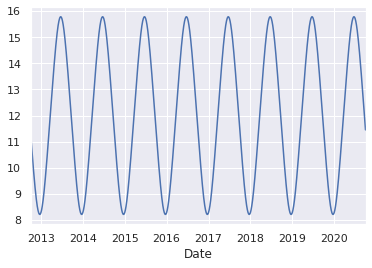

In [ ]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily['daylight_hrs'].plot();

### 4. Temperatur / 5. Niederschlag
Diese Informationen sind ganz offensichtlich nicht in den Daten vorhanden und können daraus auch nicht berechnet werden. Wir müssen daher eine zweite Datenquelle verwenden. Wir verwenden die Wetterdaten der [NOAA](https://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND). Damit Sie die Daten dort nicht einzeln bestellen müssen, stelle ich diese bei Moodle bereit. Importen Sie diese. 

*Hinweis:* Da wir die täglichen Wetterdaten unserer ``daily`` Tabelle hinzufügen wollen, wäre es wohl sinnvoll, wenn die Datumsinformationen aus der csv-Datei direkt aufbereitet würden (eben als Datum) und nicht als String (also als inhaltsleerer Text) vorliegen würden. ``pd.read_csv`` hat entsprechende Optionen.

*Hinweis:* Gehen Sie analog zum Einlesen der Datei *FremontBridge.csv*, siehe oben, vor.

In [ ]:
weather = pd.read_csv('/content/BicycleWeather2021.csv', index_col='DATE', parse_dates=True)

In [ ]:
weather.head()

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT18,WT22
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-10-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",3.0,NaN,0.0,0.0,0.0,NaN,23.3,8.9,40.0,30.0,11.2,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",4.1,NaN,0.0,0.0,0.0,NaN,17.8,10.0,10.0,20.0,8.0,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",7.3,NaN,0.0,0.0,0.0,NaN,18.9,7.8,10.0,20.0,10.3,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",6.5,NaN,0.0,0.0,0.0,NaN,18.9,8.3,20.0,20.0,9.4,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.7,NaN,0.0,0.0,0.0,NaN,21.7,8.9,360.0,360.0,8.0,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Bei der Durchschittstemperatur gibt es einige fehlende Daten (wie könnte man das herausfinden?). Legen Sie eine neue Spalte ``weather['Temp (C)']`` an, welche falls vorhanden die Durchschnittstemperatur ``TAVG`` und ansonsten als Näherung hierfür den Mittelwert aus ``TMIN`` und ``TMAX``.

*Hinweis:* Mit ``weather.loc[Zeilen, Spalten]`` kann man (auch schreibend) auf die durch Zeilen und Spalten spezifizierten Einträge zugreifen. ``weather['Temp (C)'].isnull()`` kann für die Zeilenwahl hilfreich sein.

In [ ]:
weather['Temp (C)'] = weather['TAVG']

In [ ]:
weather.loc[weather['Temp (C)'].isnull(),'Temp (C)'] = 0.5*(weather['TMAX'] + weather['TMIN'])

In [ ]:
weather.head()

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT18,WT22,Temp (C)
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-10-01,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",3.0,NaN,0.0,0.0,0.0,NaN,23.3,8.9,40.0,30.0,11.2,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.10
2012-10-02,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",4.1,NaN,0.0,0.0,0.0,NaN,17.8,10.0,10.0,20.0,8.0,9.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.90
2012-10-03,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",7.3,NaN,0.0,0.0,0.0,NaN,18.9,7.8,10.0,20.0,10.3,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.35
2012-10-04,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",6.5,NaN,0.0,0.0,0.0,NaN,18.9,8.3,20.0,20.0,9.4,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.60
2012-10-05,USW00024233,"SEATTLE TACOMA AIRPORT, WA US",5.7,NaN,0.0,0.0,0.0,NaN,21.7,8.9,360.0,360.0,8.0,9.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.30


Was den Niederschlag angeht, so wäre es evtl. auch relevant explizit zu wissen, ob es an einem Tag regnet (also ``PRCP!=0``) oder eben nicht (also ``PRCP==0``). Legen Sie hierfür eine neue Spalte ``weather[dry day]`` an, die an trockenen Tagen 1 enthält und sonst 0.

*Hinweis:* Ein Vergleich wie ``PRCP==0`` liefert einen Wahrheitswert, d.h. ``True`` oder ``False`` zurück. Damit kann unser Modell aber nicht rechnen. Ein nachgestelltes ``.astype(int)`` sorgt dafür, dass ``True`` als 1 und ``False`` als 0 angegeben wird.

In [ ]:
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

Diese Wetterdaten (also ``'PRCP', 'Temp (C)', 'dry day'``) sollen nun den ``daily`` Daten hinzugefügt werden. Hierfür gibt es die Methode ``join``: Durch den Befehl ``df1.join(df2)`` wird ein neuer DataFrame erstellt, welcher die Daten aus ``df1`` und die Daten aus ``df2`` zusammengefügt enthält. Dabei sollten die Indices der beiden DataFrames übereinstimmen.

In [ ]:
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

### 6. Trend von Jahr zu Jahr
Um einen etwa vorhandenen langfristigen Trend ggf. mit aufnehmen zu können, soll eine weiteres Feature angeben, wie viele Tage seit Beginn der Messung vergangen sind. Damit haben wir eine monoton steigende Größe.

Legen Sie ein Feature ``annual`` an, das die beschriebene Größe skaliert mit 1/365 angibt. D.h. ``annual`` soll nach einem Jahr den Wert 1, nach zwei Jahren den Wert 2  usw. haben.

*Hinweis:* Das Datum ist im Index gespeichert, auf den mit ``daily.index`` zugegriffen werden kann. ``daily.index[0]`` gibt das erste Datum als ``Timestamp`` zurück. Mit solchen Timestamps kann ganz einfach gerechnet werden, so gibt etwa die Differenz zweier Timestamps den dazwischen liegenden Zeitraum an (als ``Timedelta``-Objekt, mit ``.days`` extrahiert man daraus die Tage).

In [ ]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [ ]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0,0,1,0,0,0,0,0.0,11.277359,0.0,13.35,1,0.000000
2012-10-04,3475.0,0,0,0,1,0,0,0,0.0,11.219142,0.0,13.60,1,0.002740
2012-10-05,3148.0,0,0,0,0,1,0,0,0.0,11.161038,0.0,15.30,1,0.005479
2012-10-06,2006.0,0,0,0,0,0,1,0,0.0,11.103056,0.0,15.85,1,0.008219
2012-10-07,2142.0,0,0,0,0,0,0,1,0.0,11.045208,0.0,15.85,1,0.010959


### 7. Pandemie

In [ ]:
daily['pandemic'] = (daily.index > '2020-03-01').astype(int)

In [ ]:
daily.tail()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,pandemic
Date,,,,,,,,,,,,,,,
2020-09-26,2133.0,0,0,0,0,0,1,0,0.0,11.687302,0.0,14.2,1,7.986301,1
2020-09-27,2898.0,0,0,0,0,0,0,1,0.0,11.628541,0.0,14.8,1,7.989041,1
2020-09-28,2692.0,1,0,0,0,0,0,0,0.0,11.569831,0.0,16.0,1,7.991781,1
2020-09-29,2939.0,0,1,0,0,0,0,0,0.0,11.511182,0.0,17.7,1,7.994521,1
2020-09-30,2530.0,0,0,1,0,0,0,0,0.0,11.452601,0.0,18.1,1,7.997260,1


Wir prüfen, ob nun noch irgendwo Werte fehlen:

In [ ]:
daily.isna().sum()

Total           0
Mon             0
Tue             0
Wed             0
Thu             0
Fri             0
Sat             0
Sun             0
holiday         0
daylight_hrs    0
PRCP            0
Temp (C)        0
dry day         0
annual          0
pandemic        0
dtype: int64

## 2. Modell
Entnehmen Sie aus ``daily`` die Features Matrix ``X`` und den Labels Vektor ``y``.

In [ ]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual', 'pandemic']
X = daily[column_names]
y = daily['Total']

Trainieren Sie ein ``LinearRegression`` Modell auf die Daten. Setzen Sie den Hyperparameter ``fit_intercept=False``. Plotten Sie die erhaltenen Ergebnisse und vergleichen Sie diese (im Plot) mit den echten Daten.

*Hinweis:* Sie können (eine Auswahl) eines DataFrames ``df`` einfach plotten durch ``df[['Item_1', ..., 'Item_N']].plot(alpha=0.5)``. Dabei sorgt ``alpha=0.5`` für einen nicht deckenden Plot, so dass sich ggf. überlagernde Linien sichtbar bleiben.

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['pred_lin'] = model.predict(X)

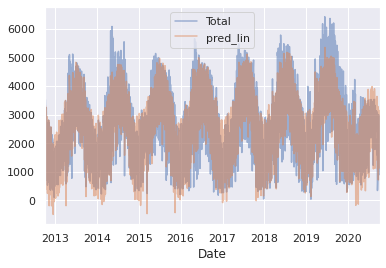

In [ ]:
daily[['Total', 'pred_lin']].plot(alpha=0.5);

Betrachten Sie auch kleinere Zeiträume im Plot (im DataFrame ``df`` können durch ``df.loc['Startdatum':'Enddatum']`` nur die entsprechenden Daten gefiltert werden).

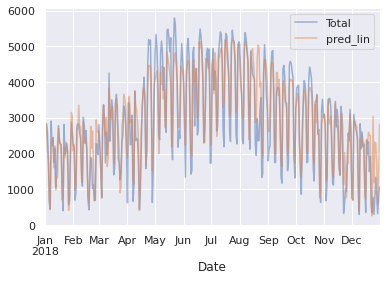

In [ ]:
daily[['Total', 'pred_lin']].loc['2018-01-01':'2018-12-31'].plot(alpha=0.5)

Da wir ein lineares Modell verwendet haben, können wir uns die einzelnen Koeffizienten gut vorstellen; diese geben jeweils an, wie stark das entsprechende Feature in den vorhergesagten Wert eingeht. Die Koeffizienten sind nach dem Training in ``model.coef_`` verfügbar und beziehen sich der Reihe nach auf die Features. Hier eine übersichtliche tabellarische Darstellung:

In [ ]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              464.253639
Tue              559.108727
Wed              546.248708
Thu              416.955905
Fri              107.929561
Sat            -1194.039178
Sun            -1255.352301
holiday        -1228.129216
daylight_hrs     119.855106
PRCP             -26.618387
dry day          549.539732
Temp (C)          71.781157
annual            83.474720
pandemic       -1289.469262
dtype: float64

- Interpretieren Sie diese Daten.
- Um die Güte dieser Abhängigkeiten einschätzen zu können, brauchen wir die Standardabweichungen dieser Werte. Diese erhalten wir, indem wir das Modell mehrfach (z.B. 1000 Mal) auf zufällig ausgewählten Daten trainieren. Dadurch erhalten wir für jeden Koeffizienten 1000 Werte, davon bestimmen wir die Standardabweichung.

In [ ]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [ ]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            464.0   64.0
Tue            559.0   66.0
Wed            546.0   65.0
Thu            417.0   65.0
Fri            108.0   63.0
Sat          -1194.0   64.0
Sun          -1255.0   64.0
holiday      -1228.0   98.0
daylight_hrs   120.0    7.0
PRCP           -27.0    2.0
dry day        550.0   27.0
Temp (C)        72.0    3.0
annual          83.0    5.0
pandemic     -1289.0   78.0


Interpretieren Sie diese Daten.

# Praktikum Session 6
In dieser Session wollen wir weiter mit den in Session 5 verwendeten Daten der Fahrradfahrten über die Seattle Fremont Bridge arbeiten.

Konkret wollen wir:

1.  Die Daten "besser treffen", d.h. ein Modell erstellen, das die gesamten Daten besser lernen kann.

Das stellt lediglich eine weitere Verbesserung der Arbeit des letzten Praktikums dar.

2.  Ein Modell mit historischen Daten trainieren, welches dann Vorhersagen für die Zukunft treffen kann.

Das ist eine prinzipiell andere Aufgabenstellung.

## Teil 1: "Daten besser treffen"
Im ertsen Teil wollen wir nun versuchen, ob wir die vorhandenen Daten mit einem anderen Modell besser lernen können.

Verwenden Sie ``Ridge`` und ``Lasso`` Regression als Modell. Bestimmen Sie jeweils einen geeigneten Parameter für den Regularisierungsparameter ``alpha``. Stellen Sie das Ergebnis des Modells jeweils grafisch dar und quantifizieren Sie die Leistung des Modells, indem Sie die $R^2$-Score sowie den *Mean Squared Error* angeben.

Warum macht der Einsatz von ``Ridge`` bzw. ``Lasso`` im aktuellen Setting eigentlich **keinen Sinn**? (Wir machen es trotzdem, um etwas zu lernen...).

*Hinweise:*

*   Die genannten Fehlermaße stehen in ``sklearn.metrics`` zur Verfügung.
*   Für das Tunen von ``alpha`` können Sie sich ggf. an dem Notebook zu Linearen Modellen orientieren.
*   Grafische Darstellungen des Ergebnisses des Modells finden Sie weiter oben im Abschnitt zu Praktikum 5.



### Ridge

### Lasso

### Metriken
Um die Performance der einzelnen Modelle übersichtlich darzustellen, können Sie z.B. den unten angelegten DataFrame verwenden.

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

algs = ['Linear', 'Ridge', 'Lasso', 'SVR Linear', 'SVR LinearC', 'SVR2', 'SVR RBF']
metrics = ['sqrt(MSE)', 'R2']

benchmark = pd.DataFrame(index=algs, columns=metrics)
benchmark.loc[['Linear', 'Ridge', 'Lasso']] = [[np.sqrt(mean_squared_error(daily['Total'], daily['pred_lin'])), r2_score(daily['Total'], daily['pred_lin'])],
                                      [np.sqrt(mean_squared_error(daily['Total'], daily['pred_ridge'])), r2_score(daily['Total'], daily['pred_ridge'])],
                                      [np.sqrt(mean_squared_error(daily['Total'], daily['pred_lasso'])), r2_score(daily['Total'], daily['pred_lasso'])]]
benchmark

,sqrt(MSE),R2
Linear,661.453,0.755127
Ridge,661.461,0.755121
Lasso,661.527,0.755072
SVR Linear,NaN,NaN
SVR LinearC,NaN,NaN
SVR2,NaN,NaN
SVR RBF,NaN,NaN


Das ist nicht wirklich besser geworden - was aber auch kein Wunder ist, da der gewählte Regularisierungsparameter stets sehr klein ist. Das wiederum ist eigentlich klar, denn das aktuell verfolgte Ziel ist es, die Daten möglichst genau zu treffen - von Generalisierung ist (noch) keine Rede.

Daher wenden wir uns anderen Modellen zu.

### Linear SVR
Verwenden Sie eine lineare Support Vector Machine, um die Daten zu modellieren. Bestimmen Sie auch hier wieder die verwendeten Fehlermaße.

Es zeigt sich, dass dieses lineare SVR Modell *wesentlich schlechter* ist als die verwendeten linearen Modelle. Das kann so eigentlich nicht sein. Woran könnte es liegen?

*Hinweis:* Welche Hyperparameter verwendet ``SVR``? Was bewirken diese? Was wollen wir in der vorliegenden Aufgabenstellung?

### Passendere Hyperparameter für SVR
Wir betrachten nun lineare SVR und Kernel SVR mit polynomiellem Kern (Grad 2) bzw. RBF Kern. Wählen Sie hierfür jeweils einen höheren Wert für ``C``, um ein wenig regularisiertes Modell zu trainieren. Geben Sie jeweils wieder die Visualisierung und auch die obige Bewertungsmetrik an.

Verwenden Sie konkret:
- Linear: ``C``=100
- Quadratisch: ``C``=100, ``gamma``=0.1
- RBF: ``C``=5000, ``gamma``=0.1

#### SVR linear

#### SVR quadratisch

#### SVR RBF

## Teil 2: Vorhersagemodell
Teilen Sie die vorliegenden Daten auf in Trainings- und Testdaten. Verwenden Sie den Zeitraum bis 31. Oktober 2018 zum Trainieren und das Jahr 01. November 2018 bis 31. Oktober 2019 zum Testen. Verwenden Sie als Modelle
- LinearRegression
- Linear SVR
- SVR mit quadratischem Kern
- SVR mit RBF Kern

Führen Sie jeweils eine Optimierung der relevantesten Hyperparameter (sofern vorhanden) durch. Stellen Sie die Vorhersage grafisch dar, zusammen mit den wahren gemessenen Werten. Geben Sie wieder die Wurzel des MSE als quantitatives Gütemaß des Modells an.

### Lineare Regression

### Lineare SVR

### Quadratische SVR

### RBF SVR